# Проект «Отток клиентов»

## Контекст

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Необходимо построить модель с предельно большим значением F1-меры.


- Предобработка данных
- Борьба с дисбалансом
- Тестирование модели
- Общие выводы


## Описание данных

Признаки

RowNumber — индекс строки в данных
CustomerId — уникальный идентификатор клиента
Surname — фамилия
CreditScore — кредитный рейтинг
Geography — страна проживания
Gender — пол
Age — возраст
Tenure — сколько лет человек является клиентом банка
Balance — баланс на счёте
NumOfProducts — количество продуктов банка, используемых клиентом
HasCrCard — наличие кредитной карты
IsActiveMember — активность клиента
EstimatedSalary — предполагаемая зарплата
Целевой признак


Exited — факт ухода клиента

In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer


RANDOM_STATE = 42

# Предобработка данных

In [412]:
data = pd.read_csv('Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [413]:
# Дроп очевидно не влияющих на уход данных
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [414]:
# fillna пропуски -1 для RandomForest
data['Tenure'] = data['Tenure'].fillna(-1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [415]:
data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [416]:
X_train_frame, X_test_frame, y_train_frame, y_test_frame = train_test_split(data.iloc[:,:-1],
                                                                            data['Exited'],
                                                                            test_size = 0.2,
                                                                            random_state = RANDOM_STATE,
                                                                            stratify = data['Exited'])


X_train_frame, X_val_frame, y_train_frame, y_val_frame = train_test_split(X_train_frame,
                                                                          y_train_frame,
                                                                          stratify = y_train_frame,
                                                                          random_state = RANDOM_STATE)

In [417]:
# Предобработка строковых данных И подготовка признаков и меток ко входу в модель

#### Данные о гендере
def sex_rewrite(x):
    if x == 'Female':
        return 0
    else:
        return 1

def preobrazovanie(spisok):
    new_spisok = [sex_rewrite(i) for i in spisok]
    return pd.DataFrame(new_spisok)



#### Создаем трансформатор данных
## Для географического признака воспользуемся OneHotEncored() т.к. Стран всего 3: ['France', 'Spain', 'Germany'] и это не накладно

from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer

geo_mapper = DataFrameMapper([
    (['Geography'], OneHotEncoder())
])

gender_mapper = DataFrameMapper([
    (['Gender'], FunctionTransformer(func = preobrazovanie)),
])

num_mapper = DataFrameMapper([
    (data.iloc[:,:-1].describe().columns.to_list(), None)
])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_mapper', num_mapper),
    ('gen_mapper', gender_mapper),
    ('geo_mapper', geo_mapper),
])


X_train = full_pipeline.fit_transform(X_train_frame)
X_val = full_pipeline.fit_transform(X_val_frame)
y_train = y_train_frame
y_val = y_val_frame
X_train.shape

(6000, 12)

In [418]:
slovar = {}
data_f1 = pd.DataFrame()
for depth in np.arange(2, 15):
    model = DecisionTreeClassifier(max_depth = depth,
                                   random_state = RANDOM_STATE)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:,1]

    f1 = f1_score(y_true = y_val,
                  y_pred = y_pred)
    auc = roc_auc_score(y_true = y_val,
                        y_score = y_pred_proba)
    slovar['depth'] = [depth]
    slovar['f_1'] = [f1]
    slovar['auc'] = [auc]
    data_depth = pd.DataFrame(slovar)
    data_f1 = pd.concat([data_f1,data_depth], axis = 0)


data_f1.sort_values(by = 'f_1', ascending = False)

,depth,f_1,auc
0,7,0.563945,0.833360
0,10,0.548431,0.773149
0,9,0.538578,0.811354
0,8,0.537994,0.820533
0,12,0.537433,0.738554
0,11,0.522628,0.763553
0,13,0.519104,0.712075
0,14,0.507266,0.687694
0,2,0.500711,0.740843
0,5,0.472973,0.827303


In [419]:
slovar = {}
data_f1 = pd.DataFrame()
for depth in np.arange(2, 15):
    model = RandomForestClassifier(max_depth = depth,
                                   random_state = RANDOM_STATE)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:,1]

    f1 = f1_score(y_true = y_val,
                  y_pred = y_pred)
    auc = roc_auc_score(y_true = y_val,
                        y_score = y_pred_proba)
    slovar['depth'] = [depth]
    slovar['f_1'] = [f1]
    slovar['auc'] = [auc]
    data_depth = pd.DataFrame(slovar)
    data_f1 = pd.concat([data_f1,data_depth], axis = 0)


data_f1.sort_values(by = 'f_1', ascending = False)  # Лучшая глубина дерева - 12 

,depth,f_1,auc
0,12,0.571429,0.855649
0,14,0.569207,0.854118
0,13,0.562798,0.849728
0,11,0.561514,0.856965
0,9,0.551282,0.857810
0,10,0.551282,0.856729
0,8,0.511551,0.858358
0,7,0.507513,0.855393
0,6,0.481928,0.850519
0,5,0.390977,0.846375


# Борьба с дисбалансом

<Axes: xlabel='Exited', ylabel='count'>

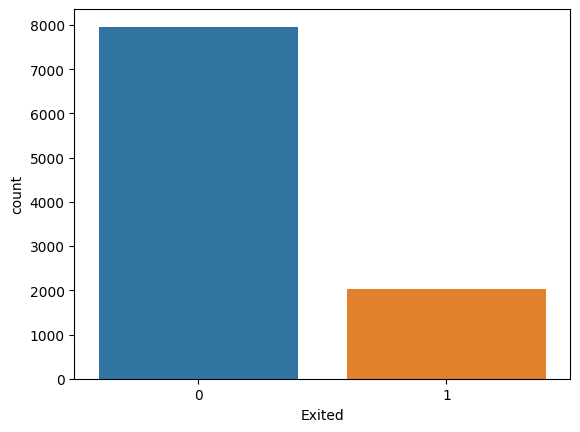

In [420]:
# Покажем этот дисбаланс
sns.countplot(data = data,
              x = 'Exited')

### RandomForest (class_weight = 'balanced')

In [421]:
# Устранение дисбаланса

grid = GridSearchCV(estimator = RandomForestClassifier(random_state = RANDOM_STATE,
                                                       class_weight = 'balanced'),
                    param_grid = {'max_depth': np.arange(2,18)},
                    scoring = 'f1',
                    n_jobs = -1,
                    cv = StratifiedShuffleSplit(test_size = 0.2,
                                                random_state = RANDOM_STATE))

grid.fit(X_train, y_train)
print(grid.best_params_)
best_model = grid.best_estimator_

print(f'Лучшая оценка f1: {grid.best_score_}') # Оценка не сильно улучшилась (0.57 --> 0.6), попробуем upsampling

{'max_depth': 9}
Лучшая оценка f1: 0.608028061018129


### Upsampling

In [422]:
# Посмотрим во сколько раз превышает класс 0
data_train = pd.concat([X_train_frame, y_train_frame], axis = 1)
count_targets = data_train.groupby('Exited')['Exited'].count()
target_0 = count_targets[0]
target_1 = count_targets[1]

upper = target_0 / target_1
upper = upper.round()   # Превышение в 4 раза
upper

4.0

In [423]:
data_train_1 = data_train[data_train['Exited'] == 1]
data_train_0 = data_train[data_train['Exited'] == 0]


data_upsampling =\
pd.concat([data_train_0, pd.concat([data_train_1] * int(upper))], axis = 0)

data_upsampling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9669 entries, 1995 to 1215
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9669 non-null   int64  
 1   Geography        9669 non-null   object 
 2   Gender           9669 non-null   object 
 3   Age              9669 non-null   int64  
 4   Tenure           9669 non-null   float64
 5   Balance          9669 non-null   float64
 6   NumOfProducts    9669 non-null   int64  
 7   HasCrCard        9669 non-null   int64  
 8   IsActiveMember   9669 non-null   int64  
 9   EstimatedSalary  9669 non-null   float64
 10  Exited           9669 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 906.5+ KB


In [424]:
X_train_frame_upsampling = data_upsampling.iloc[:,:-1]
y_train_frame_upsampling = data_upsampling['Exited']

In [425]:
data_upsampling.groupby('Exited')['Exited'].count()

Exited
0    4777
1    4892
Name: Exited, dtype: int64

In [426]:
# Предобработка нового датафрейма
X_train = full_pipeline.fit_transform(data_upsampling.iloc[:,:-1])
y_train = y_train_frame_upsampling
X_train.shape

(9669, 12)

In [427]:
grid_upsampling = GridSearchCV(estimator = RandomForestClassifier(random_state = RANDOM_STATE),
                               param_grid = {'max_depth': np.arange(2,18)},
                               scoring = 'f1',
                               n_jobs = -1,
                               cv = StratifiedShuffleSplit(test_size = 0.2,
                                                           random_state = RANDOM_STATE))

grid_upsampling.fit(X_train, y_train)
print(grid_upsampling.best_params_)
best_model_upsampling = grid_upsampling.best_estimator_

print(f'Лучшая оценка f1: {grid_upsampling.best_score_}')

{'max_depth': 17}
Лучшая оценка f1: 0.9530733709416831


### Downsampling

In [434]:
downer = int((len(data_train_0)/upper))
downer  # до такого размера нужно уменьшить набор 0 класса

1194

In [441]:
data_downsampling = pd.concat([data_train[data_train['Exited'] == 1],
                               data_train[data_train['Exited'] == 0].iloc[:downer,:]], axis = 0)
data_downsampling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2417 entries, 7248 to 7036
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      2417 non-null   int64  
 1   Geography        2417 non-null   object 
 2   Gender           2417 non-null   object 
 3   Age              2417 non-null   int64  
 4   Tenure           2417 non-null   float64
 5   Balance          2417 non-null   float64
 6   NumOfProducts    2417 non-null   int64  
 7   HasCrCard        2417 non-null   int64  
 8   IsActiveMember   2417 non-null   int64  
 9   EstimatedSalary  2417 non-null   float64
 10  Exited           2417 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 226.6+ KB


In [442]:
# Предобработка нового датафрейма
X_train = full_pipeline.fit_transform(data_downsampling.iloc[:,:-1])
y_train = data_downsampling['Exited']
X_train.shape

(2417, 12)

In [443]:
grid_downsampling = GridSearchCV(estimator = RandomForestClassifier(random_state = RANDOM_STATE),
                                 param_grid = {'max_depth': np.arange(2,18)},
                                 scoring = 'f1',
                                 n_jobs = -1,
                                 cv = StratifiedShuffleSplit(test_size = 0.2,
                                                             random_state = RANDOM_STATE))

grid_downsampling.fit(X_train, y_train)
print(grid_downsampling.best_params_)
best_model_downsampling = grid_downsampling.best_estimator_

print(f'Лучшая оценка f1: {grid_downsampling.best_score_}')

{'max_depth': 6}
Лучшая оценка f1: 0.77238645902672


### Вывод по борьбе с дисбалансом

- при дисбалансном датафрейме лучшая оценка f1 : 0.57
- при 'balanced' в RandomForest лучшая оценка f1 : 0.6
- при upsampling датафрейме лучшая оценка f1 : 0.95
- при downsampling датафрейме лучшая оценка f1 : 0.77

Выбор очевиден

# Тестирование модели

In [432]:
model = best_model_upsampling

In [444]:
X_test = full_pipeline.fit_transform(X_test_frame)
y_test = y_test_frame

In [445]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

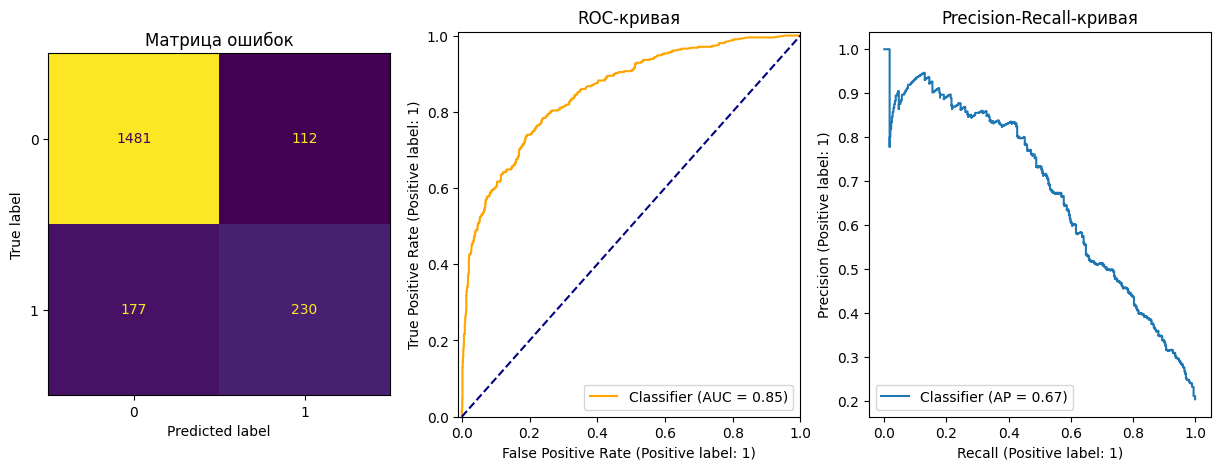

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1593
           1       0.67      0.57      0.61       407

    accuracy                           0.86      2000
   macro avg       0.78      0.75      0.76      2000
weighted avg       0.85      0.86      0.85      2000



In [446]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay.from_predictions(y_test,
                                        y_pred,
                                        ax=axes[0],
                                        colorbar=False)

axes[0].set(title='Матрица ошибок')


RocCurveDisplay.from_predictions(y_test,
                                 y_proba,
                                 ax=axes[1],
                                 color='orange')

axes[1].plot([0, 1],
             [0, 1],
             color='navy',
             linestyle='--')

axes[1].set(title='ROC-кривая',
            xlim=(-0.01, 1),
            ylim=(0, 1.01))


PrecisionRecallDisplay.from_predictions(y_test,
                                        y_proba,
                                        ax=axes[2])
axes[2].set(title='Precision-Recall-кривая')

plt.show()

print(classification_report(y_test, y_pred))

# Общий вывод:

- были рассмотрены модели DecisionTree и RandomForest - выбрана RandomForest
- 3 варианта балансировки - upbalancing лучшая
- f1_score = 0.91 / 0.61